# Supervised Classification Module

**Lecturer:** Ashish Mahabal<br>
**Jupyter Notebook Authors:** Ashish Mahabal & Yuhan Yao

This is a Jupyter notebook lesson extending the GROWTH Summer School 2019 and adapted for the NARIT-EACOA 2019 summer workshop.

## Objective
Classify different classes using (a) decision trees and (b) random forest 

## Key steps
- Pick variable types
- Select training sample
- Select method
- Look at confusion matrix and details 

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* astroquery
* pandas
* matplotlib
* pydotplus
* IPython.display
* sklearn

### External packages
None

### Partial Credits
Pavlos Protopapas (LSSDS notebook)

In [1]:
# For inline plots
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io
import pydotplus
from IPython.display import Image

# Various scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### Define datadir and files we will use

In [2]:
datadir = 'data'

# for decision tree
catalog = datadir + '/CatalinaVars.tbl.gz'
lightcurves = datadir + '/CRTS_6varclasses.csv.gz'

# for random forest
featuresfile = datadir + '/cvs_and_blazars.dat'

### Read the light curves

In [3]:
lcs = pd.read_csv(lightcurves,
                 compression='gzip',
                 header=1,
                 sep=',',
                 skipinitialspace=True,
                 nrows=100000)
                 #skiprows=[4,5])
                 #,nrows=100000)

lcs.columns = ['ID', 'MJD', 'Mag', 'magerr', 'RA', 'Dec']
lcs.head()


,ID,MJD,Mag,magerr,RA,Dec
0,1109065026725,53705.501925,16.943797,0.082004,182.25871,9.76580
1,1109065026725,53731.483314,16.645102,0.075203,182.25867,9.76585
2,1109065026725,53731.491406,16.693791,0.076497,182.25870,9.76574
3,1109065026725,53731.499465,16.793651,0.078755,182.25869,9.76576
4,1109065026725,53731.507529,16.767817,0.077436,182.25878,9.76581


In [4]:
len(lcs.groupby('ID'))

301

### Read catalog with class information for variables

In [6]:
cat = pd.read_csv(catalog,
                 compression='gzip',
                 header=5,
                 sep=' ',
                 skipinitialspace=True,
                 )

columns = cat.columns[1:]
cat = cat[cat.columns[:-1]]
cat.columns = columns

cat.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
0,CSS_J000020.4+103118,1109001041232,00:00:20.41,+10:31:18.9,14.62,1.491758,2.39,223,2
1,CSS_J000031.5-084652,1009001044997,00:00:31.50,-08:46:52.3,14.14,0.404185,0.12,163,1
2,CSS_J000036.9+412805,1140001063366,00:00:36.94,+41:28:05.7,17.39,0.274627,0.73,158,1
3,CSS_J000037.5+390308,1138001069849,00:00:37.55,+39:03:08.1,17.74,0.30691,0.23,219,1
4,CSS_J000103.3+105724,1109001050739,00:01:03.37,+10:57:24.4,15.25,1.5837582,0.11,223,8


### Get a subset of variable types, and with minimum length of light curves
### The classes are from Drake et al. 2014 and Mahabal et al. 2017
### 2: EA (detached binaries), 4: RRab, 5: RRc, 6:RRd, 8: RS CVn, 13: LPV

In [7]:
vars6 = cat[ cat['Var_Type'].isin([2,4,5,6,8,13]) & (cat['Number_Obs']>100) ]
vars6.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
0,CSS_J000020.4+103118,1109001041232,00:00:20.41,+10:31:18.9,14.62,1.491758,2.39,223,2
4,CSS_J000103.3+105724,1109001050739,00:01:03.37,+10:57:24.4,15.25,1.5837582,0.11,223,8
8,CSS_J000131.5+324913,1132001052010,00:01:31.54,+32:49:13.1,14.71,13.049549,0.17,188,8
16,CSS_J000216.1-165109,1015001002091,00:02:16.16,-16:51:09.7,16.07,0.30487,0.17,124,5
23,CSS_J000309.5+193816,1118001060639,00:03:09.56,+19:38:16.6,17.82,1.12582,0.59,206,2


### Some visualizations - these are not particularly informative, but just representative that one can try at the start of an analysis.

(13876, 9)


(array([4614., 1683., 5148.,  491.,    0., 1474.,    0.,    0.,    0.,
         466.]),
 array([ 2. ,  3.1,  4.2,  5.3,  6.4,  7.5,  8.6,  9.7, 10.8, 11.9, 13. ]),
 <a list of 10 Patch objects>)

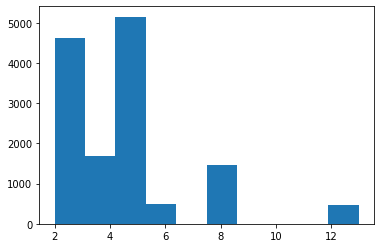

In [8]:
print(vars6.shape)
plt.hist(vars6.Var_Type)

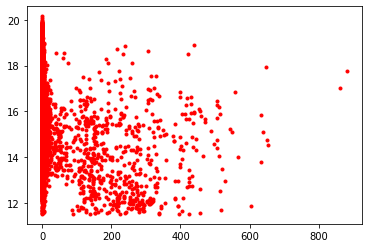

In [9]:
plt.plot(pd.to_numeric(vars6.Period_days).values, pd.to_numeric(vars6.V_mag).values, 'r.')

### Pick two classes

In [10]:
vars2 = vars6[ vars6['Var_Type'].isin([6,13])  ]
vars2.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type
115,CSS_J001420.8+031214,1104002007409,00:14:20.84,+03:12:14.0,17.45,0.3871100,0.56,174,6
174,CSS_J001616.0-173612,1018002041429,00:16:16.00,-17:36:12.4,13.87,215.564,1.17,111,13
198,CSS_J001724.9+200542,1121002007726,00:17:24.90,+20:05:42.2,16.64,0.3571291,0.39,224,6
214,CSS_J001812.9+210201,1121002027610,00:18:12.97,+21:02:01.5,14.54,0.41616,0.34,224,6
328,CSS_J002230.8-183246,1018002024540,00:22:30.83,-18:32:46.1,11.72,201.28718,1.26,111,13


### Create a 'target' column with 0|1 for the two classes

In [13]:
Y = vars2['Var_Type'].values
Y = np.array([1 if y==6 else 0 for y in Y])

In [15]:
Y[:10]

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [16]:
#X = vars2.drop('Var_Type',1).as_matrix()
X = vars2.drop('Var_Type',1)

In [27]:
#vars2['target'] = (vars2['Var_Type'].values==6)*1
#vars2['target'] = Y
vars2.loc[:,('target')] = Y

In [28]:
vars2.head()

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs,Var_Type,target
115,CSS_J001420.8+031214,1104002007409,00:14:20.84,+03:12:14.0,17.45,0.3871100,0.56,174,6,1
174,CSS_J001616.0-173612,1018002041429,00:16:16.00,-17:36:12.4,13.87,215.564,1.17,111,13,0
198,CSS_J001724.9+200542,1121002007726,00:17:24.90,+20:05:42.2,16.64,0.3571291,0.39,224,6,1
214,CSS_J001812.9+210201,1121002027610,00:18:12.97,+21:02:01.5,14.54,0.41616,0.34,224,6,1
328,CSS_J002230.8-183246,1018002024540,00:22:30.83,-18:32:46.1,11.72,201.28718,1.26,111,13,0


In [29]:
Y[:10]

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [34]:
#X[:3,:]
X[:3]

,Catalina_Surveys_ID,Numerical_ID,RA_J2000,Dec,V_mag,Period_days,Amplitude,Number_Obs
115,CSS_J001420.8+031214,1104002007409,00:14:20.84,+03:12:14.0,17.45,0.3871100,0.56,174
174,CSS_J001616.0-173612,1018002041429,00:16:16.00,-17:36:12.4,13.87,215.564,1.17,111
198,CSS_J001724.9+200542,1121002007726,00:17:24.90,+20:05:42.2,16.64,0.3571291,0.39,224


### Create a training sample with 60% of the objects

In [35]:
# Create test/train mask
itrain, itest = train_test_split(range(vars2.shape[0]), train_size=0.6)
mask=np.ones(vars2.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [36]:
mask[:10]

array([ True,  True, False,  True, False,  True, False,  True, False,
       False])

In [37]:
print("% Class 6 objects in Training:", np.mean(vars2.target[mask]), np.std((vars2.target[mask])))
print("% Class 13 objects in Testing:", np.mean(vars2.target[~mask]), np.std((vars2.target[~mask])))

% Class 6 objects in Training: 0.4965156794425087 0.49998785936285606
% Class 13 objects in Testing: 0.5378590078328982 0.49856463525395417


## A bit about Decision Trees

One builds a decision tree using one or more predictors:

Here we want to classify variable astronomical sources (e.g. EA, RRab, RRc, RRd, RS CVn, LPV etc.) using a few features we have access to viz. V_mag, Period_days, Amplitude, Number_Obs (note that not all of these may be good or useful for our purpose).

Generically let's call them  𝑋𝑖1,𝑋𝑖2,...,𝑋𝑖𝑝  ( 𝑖  for source type,  𝑝  for predictors). We also have an observed label  𝑌𝑖  for each type of variable.

We first assign everyone to the same class, say  𝑌̂ 𝑖=1 . We can calculate the squared error  𝐸𝑟𝑟=∑𝑖(𝑌̂ 𝑖−𝑌𝑖)2 
At each step of the algorithm we consider a list of possible decision (or split), for example  𝑋12>35 , i.e. period is greater than 35.
For each possible decision we recalculate the predictor for that rule, for example  𝑌̂ 𝑖=6  if  𝑋12>35  and  Y i=13 if X<35.
We recalculate the error for each possible decision:  𝐸𝑟𝑟=∑𝑖(𝑌̂ 𝑖−𝑌𝑖)2 
We choose the decision that reduces the error by the largest amount
then keep going (if there are multiple predictors). The Err term is our impurity/loss function.

### Define a few functions we will be using

In [38]:
def display_dt(dt):
    dummy_io = io.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io, proportion=True) 
    print(dummy_io.getvalue())

In [39]:
# This function creates images of tree models using pydotplus
# https://github.com/JWarmenhoven/ISLR-python
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = io.StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, proportion=True, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [40]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return(clf, Xtrain, ytrain, Xtest, ytest)

### Run the decision tree model and get a confusion matrix
### We will use the V magnitude and period as variables
### We will use the gini index

Let's first fit on two covariates to help us visualize what's going on. Have a look at the options on the help page <https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html>. We'll be optimizing over two options here: max_depth - the maximum depth of the tree, min_samples_leaf - the minimum number of samples required to be at a leaf node.

Assuming the root note is S, and S' iterates over leaf notes such that the union of S'=S. Then the Gini impurity measures L(S') = |S'|  1− p_{S'}^2 − (1− p_{S'})^2, where p_{S'} is the fraction of S' that are positive examples

<img src="data/addSlides.jpg">

In [41]:
clfTree1 = tree.DecisionTreeClassifier(max_depth=3, criterion='gini')

subdf=vars2[['V_mag', 'Period_days']]
X=subdf.values
y=(vars2['target'].values==1)*1

# TRAINING AND TESTING
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

# FIT THE TREE 
clf=clfTree1.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print("############# based on standard predict ################")
print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(confusion_matrix(ytest, clf.predict(Xtest)))
print("########################################################")

############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     1.00
[[177   0]
 [  0 206]]
########################################################


### Yeah, we got perfect classification!
### But there is a good reason for it. In fact two.
### (1) Period is not a good variable to use for classification - if you have the period of an object, you already know a lot
### (2) In this particular case, the periods for the two classes are very distinct from each other and so they are easy to separate when period is used as one of the variables.

In [42]:
len(Xtrain), len(Xtest), len(ytrain), len(ytest)

(574, 383, 574, 383)

In [43]:
display_dt(clf)

digraph Tree {
node [shape=box] ;
0 [label="X[1] <= 42.634\ngini = 0.5\nsamples = 100.0%\nvalue = [0.503, 0.497]"] ;
1 [label="gini = 0.0\nsamples = 49.7%\nvalue = [0.0, 1.0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.0\nsamples = 50.3%\nvalue = [1.0, 0.0]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


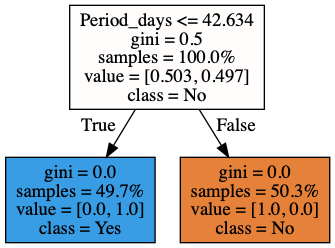

In [44]:
graph3 = print_tree(clf, features=['V_mag', 'Period_days'], class_names=['No', 'Yes'])
Image(graph3.create_png())

### Let us include all the steps above in a function

In [56]:
def dtclassify(allclasses,class1,class2,var1,var2):
    vars2 = allclasses[ allclasses['Var_Type'].isin([class1,class2])  ]
    Y = vars2['Var_Type'].values
    Y = np.array([1 if y==6 else 0 for y in Y])
#    X = vars2.drop('Var_Type',1).as_matrix()
    X = vars2.drop('Var_Type',1)
#    vars2['target'] = (vars2['Var_Type'].values==class1)*1
    vars2.loc[:,('target')] = Y
    
    # Create test/train mask
    itrain, itest = train_test_split(range(vars2.shape[0]), train_size=0.6)
    mask=np.ones(vars2.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    
    print("% Class ",class1," objects in Training:", np.mean(vars2.target[mask]), np.std((vars2.target[mask])))
    print("% Class ",class2," objects in Testing:", np.mean(vars2.target[~mask]), np.std((vars2.target[~mask])))
    
    clfTree1 = tree.DecisionTreeClassifier(max_depth=3, criterion='gini')

    subdf=vars2[[var1, var2]]
    X=subdf.values
#    y=(vars2['target'].values==1)*1
#    print('y is ',y[:10])
    y = vars2.loc[:,('target')].values==1*1
#    print('y is ',y[:10])

    # TRAINING AND TESTING
    Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

    # FIT THE TREE 
    clf=clfTree1.fit(Xtrain, ytrain)

    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    
    display_dt(clf)
    return [clf,var1,var2]
    
#    graph3 = print_tree(clf, features=[var1, var2], class_names=['No', 'Yes'])
#    Image(graph3.create_png())
    


In [49]:
# A generic function to do CV

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

### First try it again with variables we have already tried

In [57]:
dtclassify(vars6,6,13,'V_mag','Period_days')

% Class  6  objects in Training: 0.5034843205574913 0.49998785936285584
% Class  13  objects in Testing: 0.5274151436031331 0.4992478441628156
y is  [1 0 1 1 0 0 1 1 0 0]
y is  [ True False  True  True False False  True  True False False]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     1.00
[[181   0]
 [  0 202]]
########################################################
digraph Tree {
node [shape=box] ;
0 [label="X[1] <= 40.071\ngini = 0.5\nsamples = 100.0%\nvalue = [0.497, 0.503]"] ;
1 [label="gini = 0.0\nsamples = 50.3%\nvalue = [0.0, 1.0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.0\nsamples = 49.7%\nvalue = [1.0, 0.0]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'V_mag',
 'Period_days']

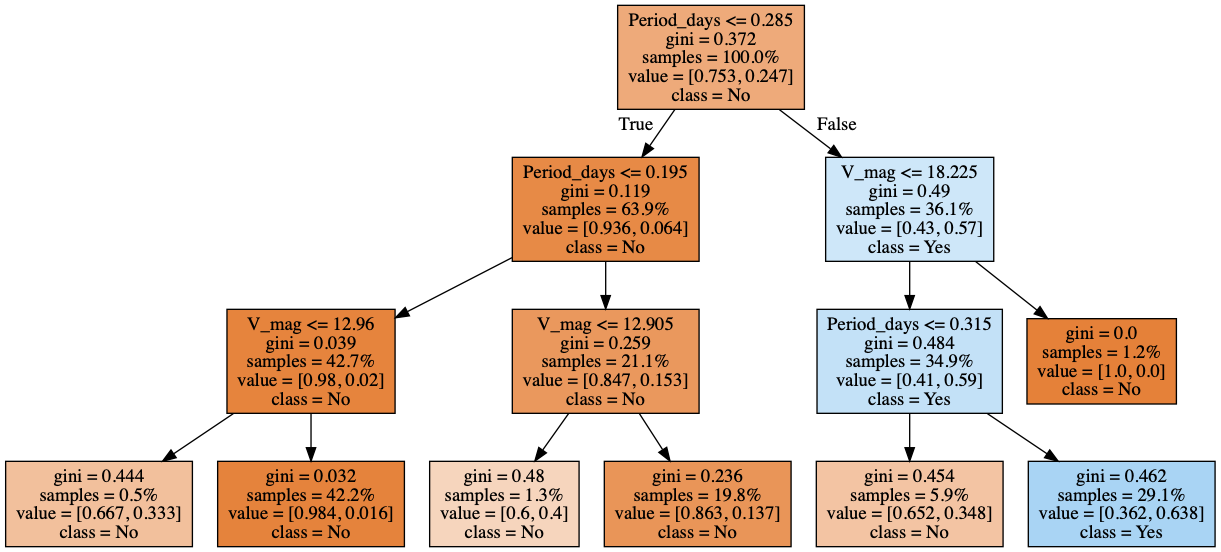

In [58]:
graph3 = print_tree(clf, features=['V_mag', 'Period_days'], class_names=['No', 'Yes'])
Image(graph3.create_png())

### And now with other classes and variables
### unbalanced classes in this case

In [69]:
[clf,var1,var2] = dtclassify(vars6,6,8,'V_mag','Amplitude')

% Class  6  objects in Training: 0.263782866836302 0.4406829540609922
% Class  8  objects in Testing: 0.22900763358778625 0.42019416624497474
y is  [0 0 0 0 0 1 1 1 0 0]
y is  [False False False False False  True  True  True False False]
############# based on standard predict ################
Accuracy on training data: 0.83
Accuracy on test data:     0.80
[[484 122]
 [ 34 146]]
########################################################
digraph Tree {
node [shape=box] ;
0 [label="X[1] <= 0.285\ngini = 0.388\nsamples = 100.0%\nvalue = [0.736, 0.264]"] ;
1 [label="X[1] <= 0.185\ngini = 0.125\nsamples = 63.2%\nvalue = [0.933, 0.067]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[1] <= 0.03\ngini = 0.027\nsamples = 37.6%\nvalue = [0.986, 0.014]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 0.1%\nvalue = [0.0, 1.0]"] ;
2 -> 3 ;
4 [label="gini = 0.022\nsamples = 37.5%\nvalue = [0.989, 0.011]"] ;
2 -> 4 ;
5 [label="X[1] <= 0.255\ngini = 0.249\nsamples = 25.6%\nvalu

/Users/aam/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/aam/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


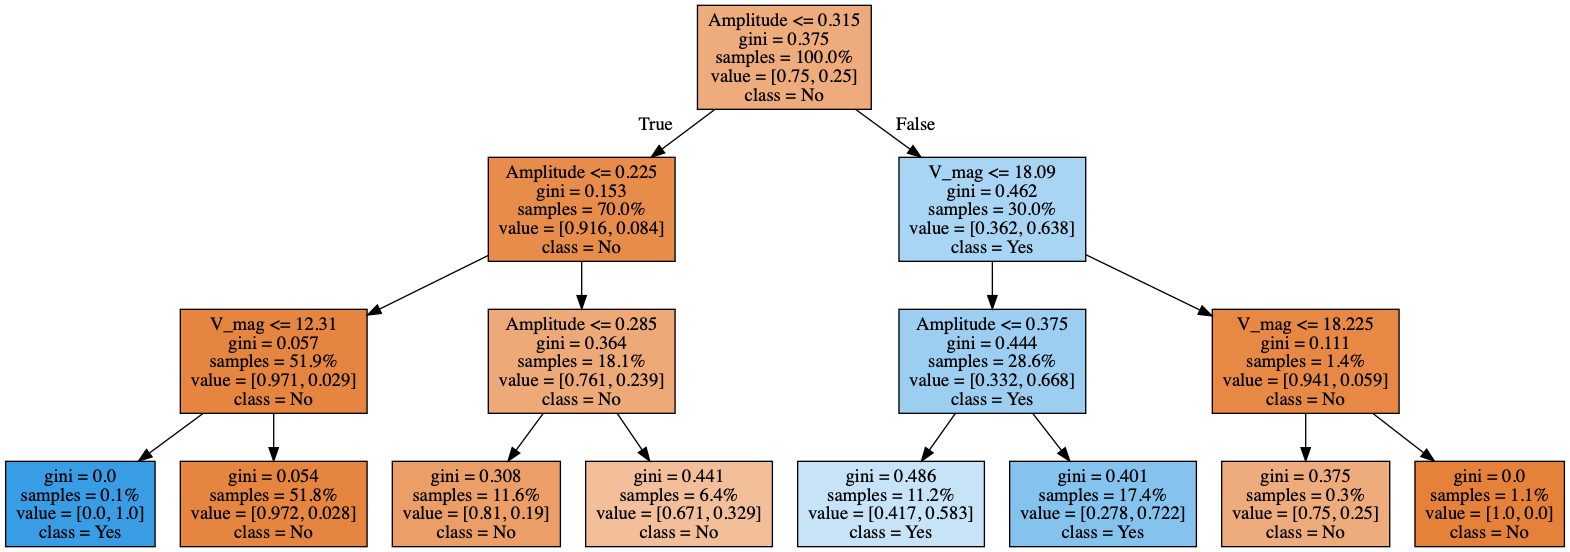

In [60]:
graph3 = print_tree(clf, features=[var1, var2], class_names=['No', 'Yes'])
Image(graph3.create_png())

In [61]:
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Lets look at features derived from light curves now, and use them to see if we can separate CVs and Blazars
### This is a different dataset than before

In [62]:
features = pd.read_csv(featuresfile,
                 header=1,
                 sep=',',
                 skipinitialspace=True,)


features.columns = ['source_id', 'id2', 'RA', 'Dec', 'gl', 'gb', 
                    'amplitude', 'beyond1std', 'fpr_mid20', 'fpr_mid35', 
                    'fpr_mid50', 'fpr_mid65', 'fpr_mid80', 'linear_trend', 
                    'max_slope', 'med_abs_dev', 'med_buf_range_per', 'pair_slope_trend', 
                    'percent_amplitude', 'pdfp', 'skew', 'kurtosis', 'std', 'magratio', 
                    'data_num', 'npeaks', 'peakstats', 'Var_Type']
features.head()

,source_id,id2,RA,Dec,gl,gb,amplitude,beyond1std,fpr_mid20,fpr_mid35,...,percent_amplitude,pdfp,skew,kurtosis,std,magratio,data_num,npeaks,peakstats,Var_Type
0,CSS071112:024457+352249,6012213501311032988,41.239291,35.380553,187.866217,-21.512745,1.221016,0.333333,0.105355,0.271527,...,0.819420,1.479632,1.023488,0.083616,0.680993,0.500000,18,0,0.0,0
1,CSS071112:085823-003729,5120100104811037790,134.595171,-0.624753,106.148755,28.031224,1.878562,0.130435,0.077322,0.203941,...,0.949115,1.369243,1.425266,0.807734,1.062428,0.478261,23,0,0.0,0
2,CSS071115:044216-002334,5102700102611041321,70.566770,-0.392723,138.476707,-27.998158,1.231619,0.285714,0.179818,0.268211,...,1.246233,1.931750,0.630285,-0.572244,0.732951,0.500000,28,1,0.0,0
3,CSS071206:060031-105208,7120600903211011601,90.129114,-10.868934,118.681166,-15.655362,0.242655,0.400000,0.049581,0.086766,...,0.407943,0.416313,-1.161945,-0.114912,0.166090,0.400000,5,0,0.0,0
4,CSS071214:090904+091714,5053110904911006068,137.268268,9.287025,114.739275,35.243473,1.225036,0.153846,0.060842,0.190844,...,0.845035,1.310212,1.534900,0.971967,0.774822,0.461538,13,0,0.0,0


In [63]:
[clf,var1,var2] = dtclassify(features,0,1,'amplitude','beyond1std')

% Class  0  objects in Training: 0.0 0.0
% Class  1  objects in Testing: 0.0 0.0
y is  [0 0 0 0 0 0 0 0 0 0]
y is  [False False False False False False False False False False]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     1.00
[[234]]
########################################################
digraph Tree {
node [shape=box] ;
0 [label="gini = 0.0\nsamples = 100.0%\nvalue = 350.0"] ;
}


### That was no classification at all! All objects were declared to be in the same class.

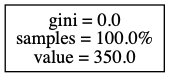

In [64]:
graph3 = print_tree(clf, features=[var1, var2], class_names=['No', 'Yes'])
Image(graph3.create_png())

## We will now use Random forests instead of individual trees

## Random Forests

Random forests works by aggregating the results from a number of randomly perturbed decision trees constructed to explain the data.

### A bit on bootstrap aggregation
The idea of random forests arises naturally by first considering Tree bagging. In tree bagging we do the following $b$ times:

1. Take a random subsample of your data
2. Build a classification (or regression) tree like in the previous section
3. repeat

For a new data point we can then simply run that point through all the $b$ trees constructed, get all the decisions $\hat{Y}_1,..., \hat{Y}_b$ and take a majority vote. This form of averaging gets rid of some of the over-fitting issues found in just using one tree. Plus fitting these trees costs a lot computationally, so what else can we do?

### Leads to Random Forests?
This method is very similar to the bootstrap aggregation method. However, as the name suggests some extra randomness is injected into the building of the trees. It turns out that the trees that are build from the random subsample of your data are quite similar, so the solution is quite simple. In Random Forests we do the following $b$ times:

1. Take a random subsample of your data
2. randomly select a subset of predictors to be used in building the tree
3. Build a classification (or regression) tree with only those variables selected in 2
4. repeat

We take a majority vote the same as before. Have a look at the help page for the [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), we'll be optimizing two options: `n_estimators` - the number of trees in the forest, `max_features` - the number of features to consider when looking for the best split (step 2 above).

### Select appropriate variables
### Note that a couple of variables chosen here are perhaps not good variables

In [65]:
Xnames

NameError: name 'Xnames' is not defined

In [66]:
Xnames = list(features.columns.values[4:-1])

### Like before we will define a training set of 60%

In [68]:
clfForest = RandomForestClassifier(n_estimators=10, oob_score=True, max_features='auto')
features['target'] = features['Var_Type']

subdf=features[Xnames]
X=subdf.values
y=(features['target'].values==1)*1

# Create test/train mask
itrain, itest = train_test_split(range(features.shape[0]), train_size=0.6)
mask=np.ones(features.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
    

# TRAINING AND TESTING
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

# FIT THE TREE 
clf=clfForest.fit(Xtrain, ytrain)

print(clfForest.n_estimators)

training_accuracy = clfForest.score(Xtrain, ytrain)
test_accuracy = clfForest.score(Xtest, ytest)
print("############# based on standard predict ################")
print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(confusion_matrix(ytest, clf.predict(Xtest)))
print("########################################################")

parameters = {"n_estimators": list(range(1, 20))}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       features, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')
print(clfForest.n_estimators)

/Users/aam/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10
############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.85
[[173   7]
 [ 29  25]]
########################################################
using mask
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.89
[[175   5]
 [ 21  33]]
########################################################
13


/Users/aam/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/aam/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aam/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


### That was not great, but who said classification was easy?
### Try with other classes, perhaps get other features, and of yes, a larger training sample with less sparse light curves.